In [87]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from bs4 import BeautifulSoup
import requests

In [88]:
page = requests.get("https://ysx-mm.com/main-board/mktdata/market-summary/")

soup = BeautifulSoup(page.content, 'html.parser')

In [89]:
table = soup.find_all('td')
tds = soup

In [91]:
second_table = soup.find('table', {'class' : "bordered dataTable no-footer", 'role' : "grid"})

In [92]:
tds = second_table.find_all("td")

data = []

for td in tds:
     td.get_text(strip=True)

In [93]:
tds = second_table.find_all("td")
data = []
rows = []

for td in tds:
    rows.append(td.get_text(strip=True))

In [94]:
num_sublists = len(rows) // 9

sublists = []

for i in range(num_sublists):
    sublist = rows[i*9 : (i+1)*9]
    sublists.append(sublist)

In [99]:
Stock_table = pd.DataFrame(sublists[:], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Trading volume',
                                                  'Trading value', 'No. of listed', 'Market Cap.'])

Stock_table['Date'] = pd.to_datetime(Stock_table['Date'])
Stock_table.set_index('Date', inplace=True)

Stock_table.columns = ['Open', 'High', 'Low', 'Close', 'Trading volume', 'Trading value',
                       'No. of listed', 'Market Cap.']

df = Stock_table

df.head()

,Open,High,Low,Close,Trading volume,Trading value,No. of listed,Market Cap.
Date,,,,,,,,
2023-08-25,392.64,395.37,390.82,395.37,"19,867","65,830,650",8,"745,736"
2023-08-24,393.14,394.17,392.41,394.17,"4,041","11,682,800",8,"743,474"
2023-08-23,394.70,394.70,390.75,394.17,"13,617","49,409,500",8,"743,474"
2023-08-22,393.48,393.68,392.26,393.68,"22,387","53,130,500",8,"742,544"
2023-08-21,388.60,391.72,388.60,391.72,"17,564","49,580,350",8,"738,865"


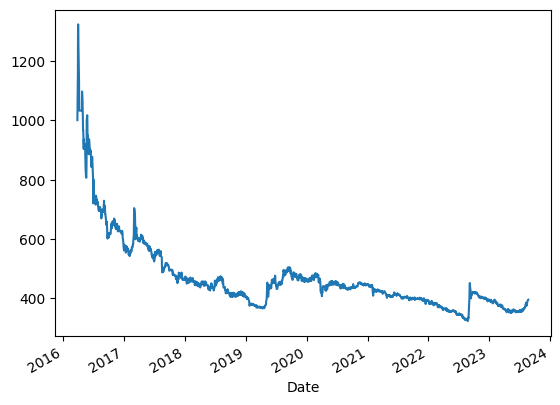

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df["Close"] = np.array([float(str_val.replace(',', '')) if isinstance(str_val, str) else float(str_val) for str_val in df["Close"]])

df["Close"].plot()

plt.show()

In [101]:
print("Dataframe Shape:", df.shape)
print("Null Value Present:", df.isnull().values.any())

Dataframe Shape: (1763, 8)
Null Value Present: False


In [102]:
output_var = pd.DataFrame(df["Close"])

features = ["Open", "High", "Low", "Trading volume"]

In [103]:
for col in features:
    df[col] = np.array([float(str_val.replace(',', '')) if isinstance(str_val, str) else float(str_val) for str_val in df[col]])

scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Trading volume
Date,,,,
2023-08-25,0.296874,0.298938,0.295498,0.094186
2023-08-24,0.297252,0.298031,0.296700,0.019086
2023-08-23,0.298432,0.298432,0.295445,0.064527
2023-08-22,0.297509,0.297661,0.296587,0.106144
2023-08-21,0.293820,0.296179,0.293820,0.083257


In [105]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [106]:
y_train = np.array([float(str_val.replace(',', '')) if isinstance(str_val, str) else float(str_val) for str_val in y_train])

In [107]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

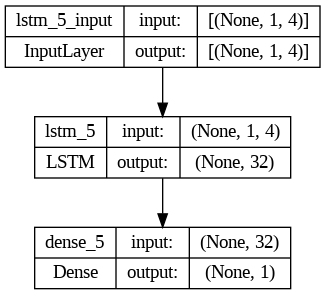

In [108]:
from keras.utils import plot_model

lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")

plot_model(lstm, show_shapes=True, show_layer_names=True)

In [109]:
history = lstm.fit(X_train, y_train, epochs=150, batch_size=8, verbose=1, shuffle=True)

Epoch 1/150
201/201 [==============================] - 2s 2ms/step - loss: 195592.4688
Epoch 2/150
201/201 [==============================] - 1s 2ms/step - loss: 190576.0469
Epoch 3/150
201/201 [==============================] - 0s 2ms/step - loss: 176918.8906
Epoch 4/150
201/201 [==============================] - 0s 2ms/step - loss: 156055.2188
Epoch 5/150
201/201 [==============================] - 0s 2ms/step - loss: 131745.4219
Epoch 6/150
201/201 [==============================] - 0s 2ms/step - loss: 106807.8359
Epoch 7/150
201/201 [==============================] - 0s 2ms/step - loss: 83169.8984
Epoch 8/150
201/201 [==============================] - 0s 2ms/step - loss: 62029.5586
Epoch 9/150
201/201 [==============================] - 0s 2ms/step - loss: 44088.2539
Epoch 10/150
201/201 [==============================] - 0s 2ms/step - loss: 29713.9160
Epoch 11/150
201/201 [==============================] - 0s 2ms/step - loss: 18887.8320
Epoch 12/150
201/201 [========================

In [110]:
y_pred= lstm.predict(X_test)

5/5 [==============================] - 0s 2ms/step


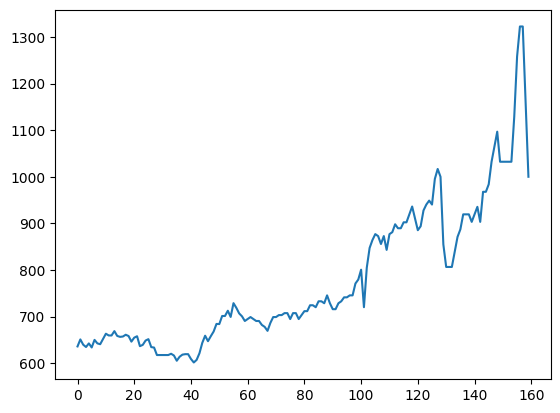

In [111]:
plt.plot(y_test, label="True Value")
plt.show()

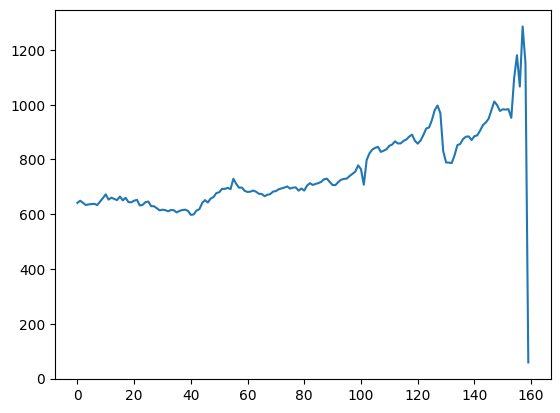

In [114]:
plt.plot(y_pred, label="True Value")
plt.show()

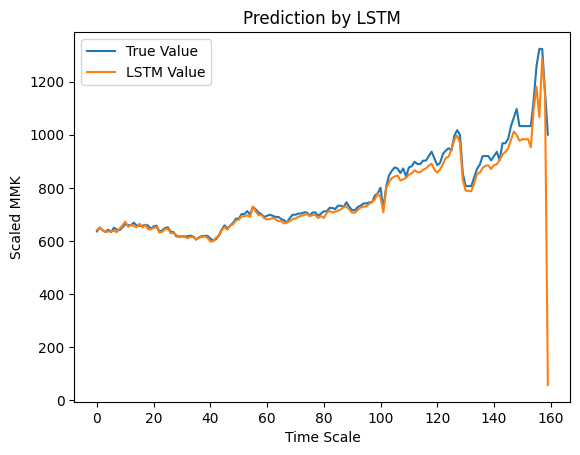

In [113]:
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled MMK")
plt.legend()
plt.show()